#Segmenting Simple Picture with Leaves Only using Sobel Edge Detection

Test Dataset: https://www.tensorflow.org/datasets/catalog/plant_leaves

In [1]:
import numpy as np
import os.path
from time import time
import types
import matplotlib.pyplot as plt
import cv2

In [2]:
import math
import numpy as np
import PIL.Image as pil
import scipy.signal as sps
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates

def compute_gradients(img):

  Ix=np.zeros_like(img)
  Iy=np.zeros_like(img)

  # extract the size of the input image
  h, w, b = img.shape

  # compute gradients using finite differences
  for y in range(1, h - 1):
      for x in range(1, w - 1):
        # compute x-gradient (Ix)
        Ix[y, x] = (img[y, x + 1] - img[y, x - 1]) / 2.0

        # Compute y-gradient (Iy)
        Iy[y, x] = (img[y + 1, x] - img[y - 1, x]) / 2.0

  return Ix, Iy

def compute_sobel(img):

  Sx=np.zeros_like(img)
  Sy=np.zeros_like(img)

  # extract dimensions of the input image
  h, w = img.shape[:2]

  # Sobel kernels
  kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  # loop through the pixels that are in the inner side of the image
  for y in range(1, h - 1):
      for x in range(1, w - 1):
          # x-gradient (Sx) using the Sobel kernel
          Sx[y, x] = np.sum(img[y - 1:y + 2, x - 1:x + 2] * kernel_x)

          # y-gradient (Sy) using the Sobel kernel
          Sy[y, x] = np.sum(img[y - 1:y + 2, x - 1:x + 2] * kernel_y)

  return Sx, Sy

def image_open(filename):
  """
  Returns a numpy float image with values in the range (0,1)
  """
  pil_im = pil.open(filename)
  im_np = np.array(pil_im).astype(np.float32)
  im_np /= 255.0
  return im_np

def image_save(im_np, filename):
  """
  Saves a numpy float image to file
  """
  if (len(im_np.shape)==2):
    im_np = np.expand_dims(im_np, 2)
  if (im_np.shape[2]==1):
    im_np= np.repeat(im_np, 3, axis=2)
  im_np = np.maximum(0.0, np.minimum(im_np, 1.0))
  pil_im = pil.fromarray((im_np*255).astype(np.uint8))
  pil_im.save(filename)

def plot_many_images(*imgs):
  """
  Plot two images and return axis handles
  """
  count = len(imgs)
  axs = []
  for i in range(count):
    axs.append(plt.subplot(1,count,i+1))
    plt.imshow(imgs[i])
    plt.axis('off')
  return axs

def normalise_01(im):
  """
  Normalise image to the range (0,1)
  """
  mx = im.max()
  mn = im.min()
  den = mx-mn
  small_val = 1e-9
  if (den < small_val):
    print('image normalise_01 -- divisor is very small')
    den = small_val
  return (im-mn)/den

def grey_to_rgb(img):
  """
  Convert greyscale to rgb image
  """
  if (len(img.shape)==2):
    img = np.expand_dims(img, 2)

  img3 = np.repeat(img, 3, 2)
  return img3

def disc_mask(l):
  """
  Create a binary cirular mask of radius l
  """
  sz = 2 * l + 1
  m = np.zeros((sz,sz))
  x = np.linspace(-l,l,2*l+1)/l
  x = np.expand_dims(x, 1)
  m = x**2
  m = m + m.T
  m = m<1
  m = np.expand_dims(m, 2)
  return m

# allow accessing these functions by im_util.*
im_util=types.SimpleNamespace()
im_util.compute_gradients=compute_gradients
im_util.compute_sobel=compute_sobel
im_util.image_open=image_open
im_util.image_save=image_save
im_util.plot_many_images=plot_many_images
im_util.normalise_01=normalise_01
im_util.grey_to_rgb=grey_to_rgb
im_util.disc_mask=disc_mask

In [3]:
"""
Helper functions
"""
# Function to compute sobel gray
def compute_sobel_gray(image_filename):
  im = im_util.image_open(image_filename)
  # Resize the image
  im = cv2.resize(im, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)

  # Compute Sobel for each color channel
  Sx_out = np.zeros_like(im)
  Sy_out = np.zeros_like(im)

  for channel in range(3):
    channel_im = im[:, :, channel]
    Sx = im_util.compute_sobel(channel_im)[0]
    Sy = im_util.compute_sobel(channel_im)[1]
    Sx_out[:, :, channel] = Sx
    Sy_out[:, :, channel] = Sy

  sobel_magnitude = np.sqrt(Sx_out**2 + Sy_out**2)
  # Convert Sobel magnitude to grayscale
  sobel_gray = cv2.cvtColor(sobel_magnitude, cv2.COLOR_RGB2GRAY)

  return im, sobel_gray

def draw_edges(im, sobel_gray):
  # Set a threshold to extract brighter pixels
  threshold_value = 0.5

  im_new = np.copy(im)

  # Mask with edge pixels marked 1
  edge_mask = np.zeros((400,600))

  # H, W = sobel_gray.shape
  for h in range(400):
    for w in range(600):
      if sobel_gray[h][w] > threshold_value:
        edge_mask[h][w] = 1.0

  for h in range(400):
    for w in range(600):
      if edge_mask[h][w] == 1.0:
        im_new[h][w] = (0,0,255)


  # Display the result
  im_util.plot_many_images(im, sobel_gray, im_new)

"""
Function to segment leaf and draw edges
"""
def segment(image_filename):
  im, sobel_gray = compute_sobel_gray(image_filename)
  draw_edges(im, sobel_gray)

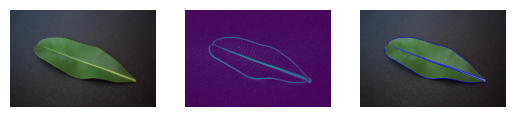

In [5]:
segment('/content/img1.jpg')

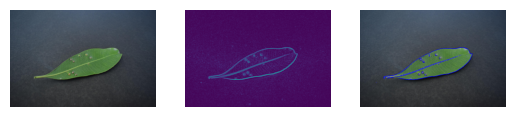

In [6]:
segment('/content/img2.jpg')

# Detecting Leaf from A More Complex Picture

In [28]:
im = im_util.image_open('/content/img3.jpg')
# Resize the image
im = cv2.resize(im, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)
# green_img = im.copy()
# green_img[:,:,0] = 0
# green_img[:,:,2] = 0
# im_util.plot_many_images(green_img)
print(im[300,200,1])

0.88175255


In [126]:
"""
Helper functions
"""
# Function to compute sobel gray
def compute_sobel_gray(image_filename):
  im = im_util.image_open(image_filename)
  # Resize the image
  im = cv2.resize(im, dsize=(600, 400), interpolation=cv2.INTER_CUBIC)

  # Compute Sobel for each color channel
  Sx_out = np.zeros_like(im)
  Sy_out = np.zeros_like(im)

  for channel in range(3):
    channel_im = im[:, :, channel]
    Sx = im_util.compute_sobel(channel_im)[0]
    Sy = im_util.compute_sobel(channel_im)[1]
    Sx_out[:, :, channel] = Sx
    Sy_out[:, :, channel] = Sy

  sobel_magnitude = np.sqrt(Sx_out**2 + Sy_out**2)
  # Convert Sobel magnitude to grayscale
  sobel_gray = cv2.cvtColor(sobel_magnitude, cv2.COLOR_RGB2GRAY)

  return im, sobel_gray

def draw_edges(im, sobel_gray):
  # Set a threshold to extract brighter pixels
  threshold_value = 0.5

  # Set a green threshold
  green_threshold_lower = 0.5
  green_threshold_upper = 0.7

  im_new = np.copy(im)

  # Mask with edge pixels marked 1
  edge_mask = np.zeros((400,600))

  # H, W = sobel_gray.shape
  for h in range(400):
    for w in range(600):
      if sobel_gray[h][w] > threshold_value:
        if im[h, w, 1] > green_threshold_lower and im[h, w, 1] < green_threshold_upper:
          edge_mask[h][w] = 1.0

  for h in range(400):
    for w in range(600):
      if edge_mask[h][w] == 1.0:
        im_new[h][w] = (255,0,0)

  # Calculate row and column densities
  row_density = np.sum(edge_mask, axis=1)
  col_density = np.sum(edge_mask, axis=0)

  # Find rows and columns with higher density
  high_density_rows = np.where(row_density > 0.43 * max(row_density))[0]
  high_density_cols = np.where(col_density > 0.43 * max(col_density))[0]

  # Find the bounding box around the region with higher density
  min_row, max_row, min_col, max_col = min(high_density_rows), max(high_density_rows), min(high_density_cols), max(high_density_cols)

  # Draw a rectangle around the region with higher density
  cv2.rectangle(im_new, (min_col, min_row), (max_col, max_row), (0, 255, 0), 2)  # Draw a green rectangle


  # Display the result
  im_util.plot_many_images(im, sobel_gray, im_new)

"""
Function to segment leaf and draw edges
"""
def segment(image_filename):
  im, sobel_gray = compute_sobel_gray(image_filename)
  draw_edges(im, sobel_gray)

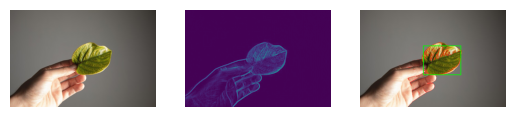

In [127]:
segment('/content/img3.jpg')

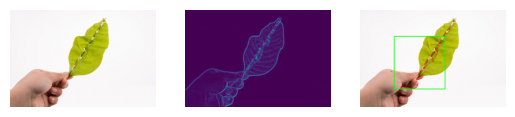

In [128]:
segment('/content/img4.jpg')